# Task

Import required libraries (for the requirements please navigate to requirements.txt in the folder)

In [1]:
import os
import requests
import re
import io
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from datetime import datetime
import fastparquet
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the data path, chart path and number of files to be downloaded
data_path = "data"
chart_path = "charts"
# Create folders if they don't exist
os.makedirs(data_path, exist_ok=True)
os.makedirs(chart_path, exist_ok=True)
# The link to the data
url = "https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/ap2y/lms/previous/"
base_url = "https://www.ons.gov.uk"
number_of_files = 24

## 1. Data Ingestion & Automation

This section parses HTML to identify and collect all relevant csv data files. For each vintage, it generates a corresponding 
vacancy_data_{releasedate}.csv file containing the extracted data. The csv files are saved under "/data" folder. While csv is a widely used format and sufficient for these relatively small datasets, it becomes less efficient as data volume grows. For larger datasets, Parquet is a better choice due to its better read/write performance, file size compression and compatibility with big data tools like Spark. I added the relevant codes to also save the data as Parquet files named as vacancy_data_{releasedate}.parquet. However, since Parquet is not strictly necessary for the current dataset, I’ve commented out the Parquet-related code in the following sections. This allows easy reactivation if the data volume increases or if integration with big data tools becomes relevant.

### 1.1 Read Target Page Content

In [3]:
# Send request with headers to mimic a browser
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers, verify=False)

### 1.2 Identify CSV Files in the Page Content 

In [4]:
# Parse HTML
soup = BeautifulSoup(response.content, "html.parser")

# Find all <a> tags with the csv download class
links = soup.find_all("a", attrs={"data-gtm-type": "download-version-csv"})

In [5]:
def download_csv_file(file_link, base_url, data_path):
    """
    Downloads a CSV file from a constructed URL and saves it locally with a filename 
    based on the release date extracted from the file content.

    Args:
        
        file_link (bs4.element.Tag): A BeautifulSoup tag object representing an <a> element, 
                                     expected to contain 'href' and 'data-gtm-date' attributes.
        base_url (str): The base URL to prepend to the 'href' to form the full download URL.
        data_path (str): The local directory path where the CSV file will be saved.

    Behavior:
        - Constructs the full URL using `base_url` and the 'href' from `file_link`.
        - Sends a GET request to download the CSV file.
        - Extracts the release date from the file content using a regular expression.
        - Formats the release date as 'YYYYMMDD' and uses it in the filename to make the files chronogically ordered.
        - Saves the file to `data_path` with the name 'vacancy_data_<release_date>.csv' and 'vacancy_data_<release_date>.parquet'.
        - If the release date is not found, defaults to 'vacancy_data_000.csv' and 'vacancy_data_000.parquet'.
        - Prints status messages indicating success or failure.

    Note:
        SSL verification is disabled in the request (`verify=False`), which may pose a security risk.
    """

    
    href = file_link.get("href")
    date_superseded = file_link.get("data-gtm-date")
    full_url = base_url + href
    
    print(f"{date_superseded}: {full_url}")

    response = requests.get(full_url, verify=False)

    if response.status_code == 200:
        # Decode content to string
        content = response.content.decode("utf-8")

        # Extract release date using regex
        match = re.search(r'"Release date","([\d\-]+)"', content)
        if match:
            release_date = match[1].replace("-", "")  # e.g., "12082025"
            parsed_date = datetime.strptime(release_date, "%d%m%Y")
            release_date = parsed_date.strftime("%Y%m%d") # Format the release date to YYYYMMDD so that downloaded files are named in chronological order
            filename_csv = os.path.join(data_path, f"vacancy_data_{release_date}.csv")
            filename_parquet = os.path.join(data_path, f"vacancy_data_{release_date}.parquet")
        else:
            filename_csv = os.path.join(data_path, f"vacancy_data_000.csv")
            filename_parquet = os.path.join(data_path, f"vacancy_data_000.parquet")

        # Save file
        with open(filename_csv, "w", encoding="utf-8") as f:
            f.write(content)

        # Save as Parquet
        df = pd.read_csv(io.StringIO(content))
        df.to_parquet(filename_parquet, engine="fastparquet", index=False)

        print(f"Downloaded and saved as '{filename_csv}'")
    else:
        print(f"Failed to download {release_date}. Status code: {response.status_code}")


In [6]:
# Download the first 24 files 
for link in links[:number_of_files]:
    download_csv_file(link, base_url, data_path)

Latest: https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/ap2y/lms
Downloaded and saved as 'data\vacancy_data_20250916.csv'
16 September 2025: https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/ap2y/lms/previous/v117
Downloaded and saved as 'data\vacancy_data_20250812.csv'
12 August 2025: https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/ap2y/lms/previous/v116
Downloaded and saved as 'data\vacancy_data_20250717.csv'
17 July 2025: https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/ap2y/lms/previous/v115
Downloaded and saved as 'data\vacancy_data_20250610.csv'
10 June 2025: https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/time

## 2. Data Cleaning & Structuring

This section brings together multiple files containing job vacancy data and combines them into one organized dataset. It starts by identifying the point in each file where consistent monthly data begins, then aligns all the data by month. Each file represents a different vintage. Once everything is aligned and sorted by date, the consolidated data is saved into the files "whole_vacancy_data.csv" and "whole_vacancy_data.parquet".

In [6]:
def process_vacancy_csv(file):
    """
    Processes a vacancy csv file by cleaning and transforming its contents into a time series format.

    Args:
        file (str): The csv file that will be processed.

    Returns:
        pd.DataFrame: A cleaned DataFrame with:
            - 'Date' as the index in 'YYYY-MM' format.
            - One column named after the vintage date extracted from the filename.

    Processing steps:
        - Read the csv file.
        - Cleans the 'Title' column by collapsing multiple spaces into one.
        - Converts the 'Title' column to title case and parses it as a date in 'YYYY MMM' format.
        - Drops rows where the 'Title' column could not be parsed as a date.
        - Formats the parsed dates to 'YYYY-MM'.
        - Infers a vintage identifier from the filename and renames the column accordingly.
        - Sets the 'Date' column as the index.
    """
    # Read the csv file
    df = pd.read_csv(os.path.join(data_path, file)) 
    # Read the parquet file
    #df = pd.read_parquet(os.path.join(data_path,file))
    
    # Replace multiple spaces with one space in Title column
    df['Title'] = df['Title'].apply(lambda x: re.sub(r'\s+', ' ', x))
    # Convert Title column into date having YYYY MMM format
    df["Title"] = df["Title"].str.title()
    df["Title"] = pd.to_datetime(df["Title"], format='%Y %b', errors='coerce')
    # Drop non-date columns
    df = df.dropna(subset="Title")
    # Convert Date column into YY-MM format
    df["Title"] = df["Title"].dt.strftime("%Y-%m")
    
    # Infer the vintage date from the file name
    vintage_date = file.replace("vacancy_data_","v_").replace(".csv", "") 
    #vintage_date = file.replace("vacancy_data_","v_").replace(".parquet", "") 
    # Rename columns as Date and vintage date identifier
    df.columns = ["Date", vintage_date]
    # Set Date as index
    df = df.set_index("Date")

    return df

In [7]:
# List all csv/parquet files in the current directory that start with "vacancy_data"
data_files = [f for f in os.listdir(data_path) if f.startswith("vacancy_data") and f.endswith(".csv")]
#data_files = [f for f in os.listdir(data_path) if f.startswith("vacancy_data") and f.endswith(".parquet")]

In [8]:
combined_df = []
for file in data_files:
    df = process_vacancy_csv(file)
    combined_df.append(df)

In [9]:
# Merge dataframes in combined df list into a dataframe
combined_df = pd.concat(combined_df, axis=1)
combined_df = combined_df.sort_index().reset_index()
combined_df.head()

,Date,v_20230912,v_20231114,v_20231212,v_20240116,v_20240213,v_20240312,v_20240416,v_20240514,v_20240611,...,v_20241217,v_20250121,v_20250218,v_20250320,v_20250415,v_20250513,v_20250610,v_20250717,v_20250812,v_20250916
0,2001-05,680,680,680,680,680,680,680,680,680,...,680,680,680,680,680,680,680,680,680,680
1,2001-06,674,674,674,674,674,674,674,674,674,...,674,674,674,674,674,674,674,674,674,674
2,2001-07,663,663,663,663,663,663,663,663,663,...,663,663,663,663,663,663,663,663,663,663
3,2001-08,663,663,663,663,663,663,663,663,663,...,663,663,663,663,663,663,663,663,663,663
4,2001-09,639,639,639,639,639,639,639,639,639,...,639,639,639,639,639,639,639,639,639,639


In [10]:
# Save the consolidated data as a csv/parquet file
combined_df.to_csv(os.path.join(data_path, "whole_vacancy_data.csv"), index=False)
#combined_df.to_parquet(os.path.join(data_path, "whole_vacancy_data.parquet"), index=False)

## 3. Visualisation

The code creates two types of visual tools to explore job vacancy data over time.

**a. Interactive Chart:** It builds a dynamic chart that lets you select a specific month and highlight how vacancy estimates for that month have changed across different vintages. You can switch between months using a dropdown menu, making it easy to compare revisions.

**b.Static Timeseries Chart:** It also creates a static chart showing how vacancy estimates have evolved over time for each data release. This version includes a slider so you can zoom in on specific periods and explore changes more closely.

Both visualizations are saved as HTML files, allowing you to open them in a web browser.

## a. Interactive Chart

In [11]:
# Load the consolidated csv file. !!!Notice: If you run the code from the start, no need to run this cell.
combined_df = pd.read_csv(os.path.join(data_path, "whole_vacancy_data.csv"))

In [12]:
# Load the consolidated parquet file. !!!Notice: If you run the code from the start, no need to run this cell.
#combined_df = pd.read_parquet(os.path.join(data_path, "whole_vacancy_data.parquet"))

In [13]:
# Melt the data to long format for easier filtering
melted_df = combined_df.melt(id_vars="Date", var_name="Vintage", value_name="Vacancy").dropna()

In [14]:
# Create a list of available months for dropdown menu
available_months = sorted(combined_df["Date"].dropna().unique())

# Create dropdown buttons for each month
dropdown_buttons = []
for month in available_months:
    visible = melted_df["Date"] == month
    filtered_df = melted_df[visible]
    trace = go.Scatter(x=filtered_df["Vintage"], y=filtered_df["Vacancy"], name=month)
    dropdown_buttons.append(dict(
        label=month,
        method="update",
        args=[
            {"x": [filtered_df["Vintage"]],
             "y": [filtered_df["Vacancy"]],
             "type": "line"},
            {"title": {"text": "Vacancy Estimates Across Vintages", "x": 0.5, "xanchor": "center"}}
        ]
    ))

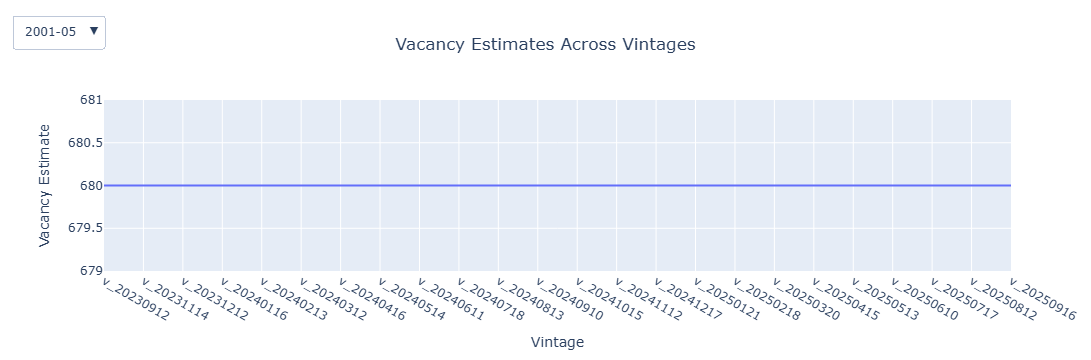

In [15]:
# Initialize figure with the first month
initial_month = available_months[0]
initial_df = melted_df[melted_df["Date"] == initial_month]
fig = go.Figure(data=[go.Scatter(x=initial_df["Vintage"], y=initial_df["Vacancy"], name=initial_month)])

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=dropdown_buttons,
        x=0,
        xanchor="right",
        y=1.5,
        yanchor="top"
    )],
    title=dict(
        text="Vacancy Estimates Across Vintages",
        x=0.5,
        xanchor="center"
    ),
    xaxis_title="Vintage",
    yaxis_title="Vacancy Estimate",
    showlegend=False
)

In [16]:
# Save the interactive chart as an HTML file
fig.write_html(os.path.join(chart_path,"vacancy_chart_interactive.html"), auto_open=False)

## b. Static Chart

In [17]:
# Load the consolidated csv file. !!!Notice: If you run the code from the start, no need to run this cell.
combined_df = pd.read_csv(os.path.join(data_path,"whole_vacancy_data.csv"))

In [18]:
# Load the consolidated parquet file. !!!Notice: If you run the code from the start, no need to run this cell.
#combined_df = pd.read_parquet(os.path.join(data_path, "whole_vacancy_data.parquet"))
#combined_df.iloc[:, 1:] = combined_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

In [19]:
# Create a line chart with each vintage as a separate trace
fig = go.Figure()

for vintage in combined_df.columns[1:]:
    fig.add_trace(go.Scatter(x=combined_df["Date"], y=combined_df[vintage], mode='lines', name=vintage))

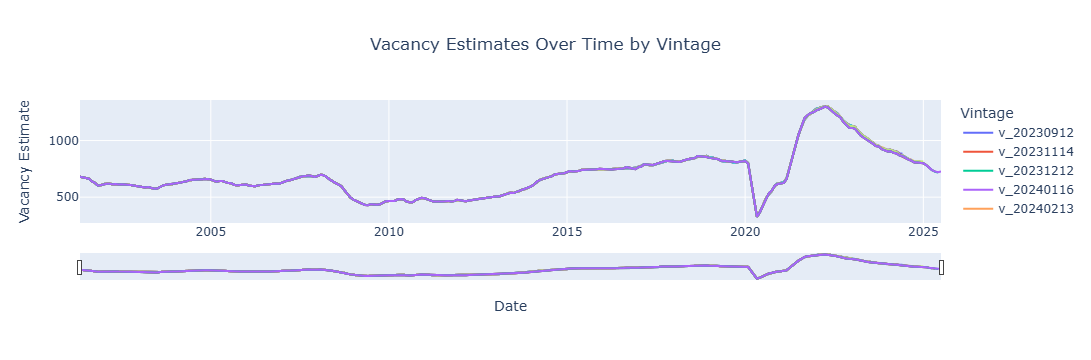

In [20]:
# Update layout with slider
fig.update_layout(
    title=dict(text="Vacancy Estimates Over Time by Vintage", x=0.5, xanchor="center"),
    xaxis_title="Date",
    yaxis_title="Vacancy Estimate",
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    ),
    legend_title="Vintage"
)

In [21]:
# Save the static chart as an HTML file
fig.write_html(os.path.join(chart_path,"vacancy_chart_static.html"), auto_open=False)

## 4.  Forecasting

The section fits an ARIMA model to forecast future vacancy levels. ARIMA is a powerful method to forecast future values based on past data, especially for time series data. The results are visualized in a chart that shows both the actual data and the forecasted values.

In [22]:
# Load the consolidated csv file. !!!Notice: If you run the code from the start, no need to run this cell.
combined_df = pd.read_csv(os.path.join(data_path,"whole_vacancy_data.csv"))

In [23]:
# Load the consolidated parquet file. !!!Notice: If you run the code from the start, no need to run this cell.
#combined_df = pd.read_parquet(os.path.join(data_path, "whole_vacancy_data.parquet"))

In [24]:
# Convert 'Date' column to datetime format
combined_df["Date"] = pd.to_datetime(combined_df["Date"])

To assess the performance of a forecasting model, we can use out-of-sample evaluation, which means testing the model on data it hasn’t seen before. One practical approach is to exclude the most recent three months of data and generate forecasts using only the information available prior to that period. **Because the data may be revised with each release, it’s important to use the version of the data that was available three months earlier (the data in vintage t-4) when making the forecast.**  We then compare the model’s predictions with the actual values from the latest data release to evaluate accuracy. To measure how close the forecasts are to the actual values, we can use common error metrics such as RMSE, MAE, MAPE etc.

In [25]:
# Use the vintage at t-4 as the train data and the latest vintage as the test data
train_df = combined_df.iloc[:,[0,-4]]

# Create time series
ts = train_df.set_index("Date").dropna()
ts = ts.astype(float)

In [26]:
print("ADF Statistic:", adfuller(ts)[0], "p-value:", adfuller(ts)[1])

ADF Statistic: -1.8279829672704817 p-value: 0.3666600674342031


In [27]:
# Take the log-transformation and check the stationarity
ts = np.log(ts)
print("ADF Statistic:", adfuller(ts)[0], "p-value:", adfuller(ts)[1])

ADF Statistic: -2.624810758312954 p-value: 0.08797703755493524


After applying a log transformation, the p-value from the stationarity test is larger than 0.05 but less than 0.10, indicating the series is still not stationary at 5% significance level. Let's try the log difference to further address non-stationarity.

In [28]:
log_diff = np.log(ts).diff().dropna()
print("ADF Statistic:", adfuller(log_diff)[0], "p-value:", adfuller(log_diff)[1])

ADF Statistic: -5.280714680950181 p-value: 6.002454626801448e-06


Once I apply the first difference to the log-transformed series, the p-value drops below 0.01, **indicating that the transformation successfully achieves stationarity.** Therefore, we can set d = 1 in the ARIMA(p, d, q) model to account for this differencing step. After playing with multiple parameter configurations, I selected the **(2,1,0)** specification because it offers the simplest structure while achieving a lower AIC and smaller prediction errors.

In [29]:
# Fit ARIMA model
model = ARIMA(ts, order=(2, 1, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             v_20250610   No. Observations:                  288
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 594.191
Date:                Thu, 09 Oct 2025   AIC                          -1182.382
Time:                        10:47:20   BIC                          -1171.404
Sample:                    05-01-2001   HQIC                         -1177.982
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7927      0.030     26.520      0.000       0.734       0.851
ar.L2         -0.2441      0.042     -5.880      0.000      -0.325      -0.163
sigma2         0.0009   2.24e-05     41.477      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):             39570.76
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):              14.55   Skew:                             2.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        60.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# Forecast the next 3 months
forecast = model_fit.forecast(steps=3)

In [31]:
# Add forecasted values to the test_df as a new column
test_df = combined_df.iloc[:,[0,-1]]
test_df.loc[test_df.index[-3:], "Forecast"] = forecast.values
test_df.iloc[:,1] = np.log(test_df.iloc[:,1].astype(float))

In [32]:
# Check the data
test_df.tail(10)

,Date,v_20250916,Forecast
281,2024-10-01,6.693324,NaN
282,2024-11-01,6.692084,NaN
283,2024-12-01,6.689599,NaN
284,2025-01-01,6.683361,NaN
285,2025-02-01,6.663133,NaN
286,2025-03-01,6.635947,NaN
287,2025-04-01,6.605298,NaN
288,2025-05-01,6.587550,6.582758
289,2025-06-01,6.579251,6.575948
290,2025-07-01,6.590301,6.575058


In [33]:
# Calculate error metrics
rmse = np.sqrt(np.mean((test_df.iloc[-3:,1] - test_df.iloc[-3:,2])**2))
mae = np.mean(np.abs(test_df.iloc[-3:,1] - test_df.iloc[-3:,2]))
mape = np.mean(np.abs((test_df.iloc[-3:,1] - test_df.iloc[-3:,2]) / float(test_df.iloc[-3,1])))*100
print(f"Several error measures: [RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%]")

Several error measures: [RMSE: 0.01 | MAE: 0.01 | MAPE: 0.12%]


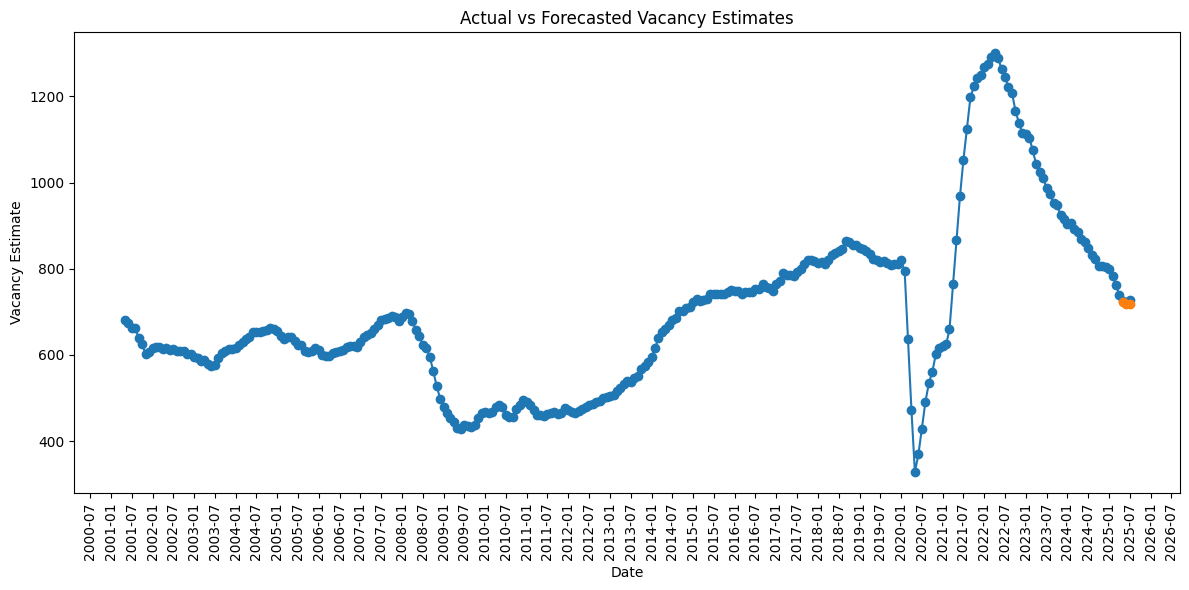

In [34]:
# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], np.exp(test_df.iloc[:, 1].astype(float)), label="Actual", marker='o')
plt.plot(test_df["Date"], np.exp(test_df["Forecast"]), label="Forecast", marker='o')
# Set x-axis ticks every 3 months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=90)
# Titles and labels
plt.title("Actual vs Forecasted Vacancy Estimates")
plt.xlabel("Date")
plt.ylabel("Vacancy Estimate")
plt.legend
plt.tight_layout()
plt.show()

This task utilizes vacancy data across different vintages, which allows for the application of basic time series forecasting techniques. Using this data alone, I can implement foundational models such as ARIMA and exponential smoothing, which are strong tools to capture temporal patterns and trends in time series data. To improve the accuracy and robustness of the forecasts, the next step can involve incorporating external macroeconomic indicators such as inflation rates, GDP growth, and potentially labor market metrics like wage growth, churn rates, hours worked. These variables can help explain structural shifts or cyclical behavior in vacancy trends. With the inclusion of these external factors, I can apply more sophisticated modeling approaches like VARs, ECM and machine learning models (Random Forests, LSTM) to capture multivariate relationships.